<a href="https://colab.research.google.com/github/xvmon234-ai/Learning-Python/blob/main/Card_Fraud_Detection_Project/04_Final_Analysis_and_Visualization/Final_Analysis_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **4.1 데이터 불러오기 및 전처리**

In [2]:
# 4.1 데이터 불러오기 및 전처리
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import warnings
warnings.filterwarnings('ignore') # 일부 경고 메시지 무시

# 4.1.1. 데이터 불러오기
file_path = 'creditcard.csv'
df = pd.read_csv(file_path)

if df['Class'].isnull().sum() > 0:
    print("Class 열에 결측치가 있어 해당 행을 삭제합니다.")
    df.dropna(subset=['Class'], inplace=True)
else:
    print("Class 열에 결측치가 없습니다. 정상 진행합니다.")

# 4.1.2. Amount 피처 로그 변환
# np.log1p를 사용해 0인 값에 대한 로그 변환 오류를 방지합니다.
df['Log_Amount'] = np.log1p(df['Amount'])

# 4.1.3. Time, Amount 피처 스케일링
scaler = StandardScaler()
df['Scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 4.1.4. 원본 피처 삭제
df = df.drop(['Time', 'Amount'], axis=1)

# 4.1.5. 훈련/테스트 데이터 분할
# 'stratify=y' 옵션으로 클래스 비율을 유지하며 데이터를 분할합니다.
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 4.1.6. 클래스 불균형 해소 (SMOTE 적용)
# 훈련 데이터에만 SMOTE를 적용해 이상 거래 샘플 수를 늘립니다.
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 4.2.1. 모델 불러오기 및 훈련
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# 로지스틱 회귀 모델
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_resampled, y_resampled)
y_proba_lr = model_lr.predict_proba(X_test)[:, 1]

# 랜덤 포레스트 모델
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_resampled, y_resampled)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# LightGBM 모델
model_lgb = lgb.LGBMClassifier(random_state=42)
model_lgb.fit(X_resampled, y_resampled)
y_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]

print("데이터 및 모델 준비 완료.")

Class 열에 결측치가 없습니다. 정상 진행합니다.
[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
데이터 및 모델 준비 완료.


### **4.2. 핵심 분석 결과 시각화**

####**4.2.1 클래스 불균형 시각화**

모델 학습의 가장 큰 난관이었던 클래스 불균형 문제를 시각적으로 다시 확인합니다.

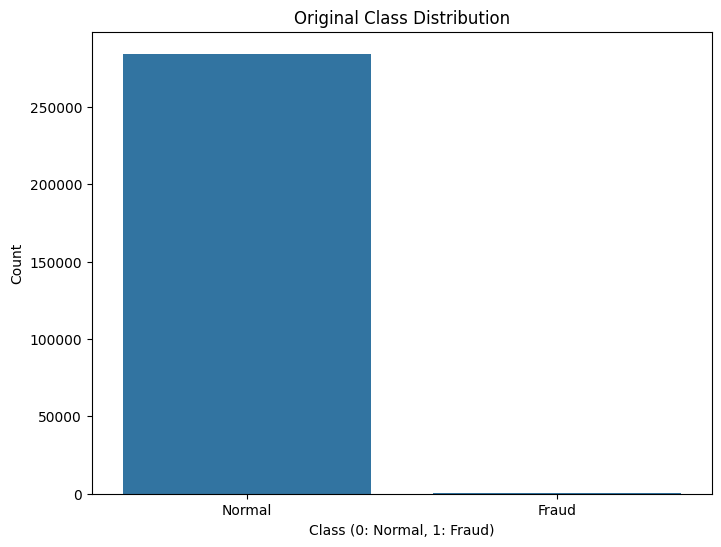

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Original Class Distribution')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Fraud'])
plt.show()

####**4.2.2. Time vs Amount 히트맵**

Time과 Amount 피처의 2차원 분포를 시각화하여, 이상 거래가 특정 패턴을 가지고 있음을 보여줍니다.

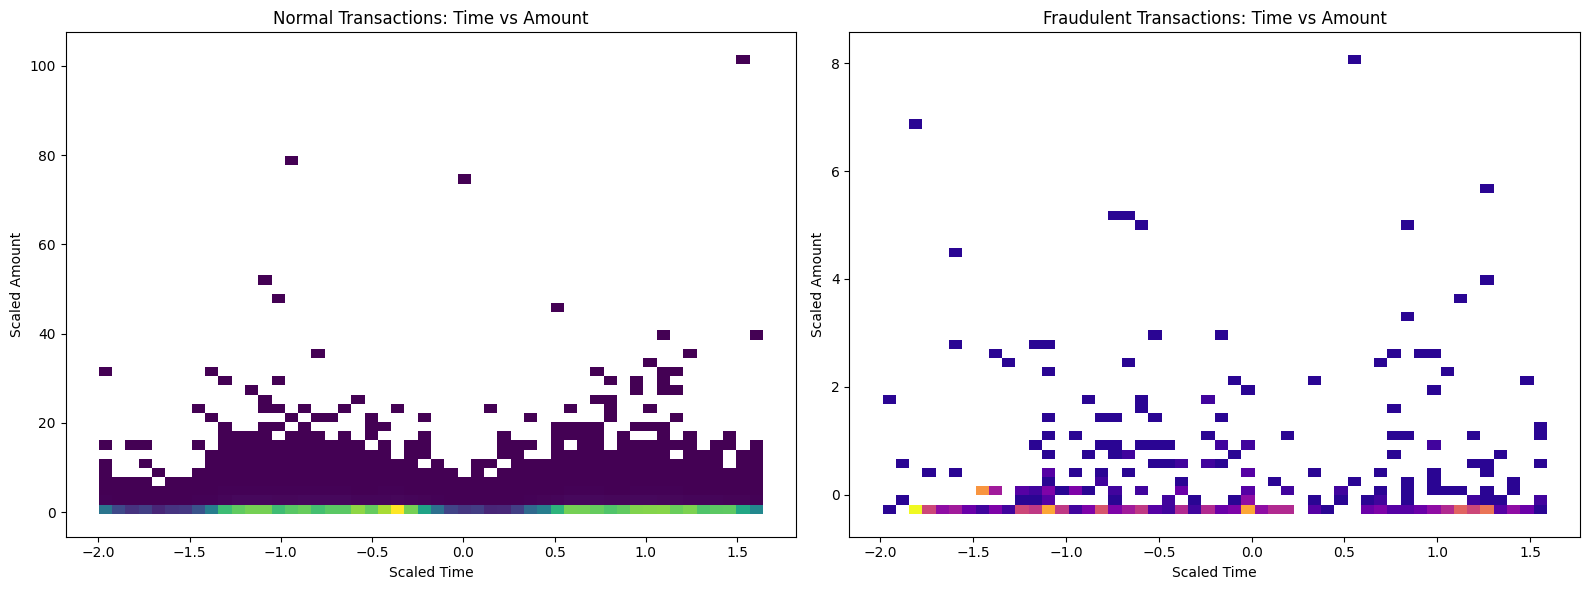

In [4]:
# 정상 거래와 이상 거래 데이터 분리
normal_df = df[df['Class'] == 0]
fraud_df = df[df['Class'] == 1]

plt.figure(figsize=(16, 6))

# 정상 거래 히트맵
plt.subplot(1, 2, 1)
sns.histplot(x=normal_df['Scaled_Time'], y=normal_df['Scaled_Amount'], bins=50, cmap="viridis")
plt.title('Normal Transactions: Time vs Amount')
plt.xlabel('Scaled Time')
plt.ylabel('Scaled Amount')

# 이상 거래 히트맵
plt.subplot(1, 2, 2)
sns.histplot(x=fraud_df['Scaled_Time'], y=fraud_df['Scaled_Amount'], bins=50, cmap="plasma")
plt.title('Fraudulent Transactions: Time vs Amount')
plt.xlabel('Scaled Time')
plt.ylabel('Scaled Amount')

plt.tight_layout()
plt.show()

####**4.2.3. 최종 모델 성능 비교: ROC Curve**

세 모델의 ROC 곡선을 한 그래프에 그려, 어떤 모델이 이상 거래와 정상 거래를 가장 잘 구별하는지 시각적으로 비교합니다.

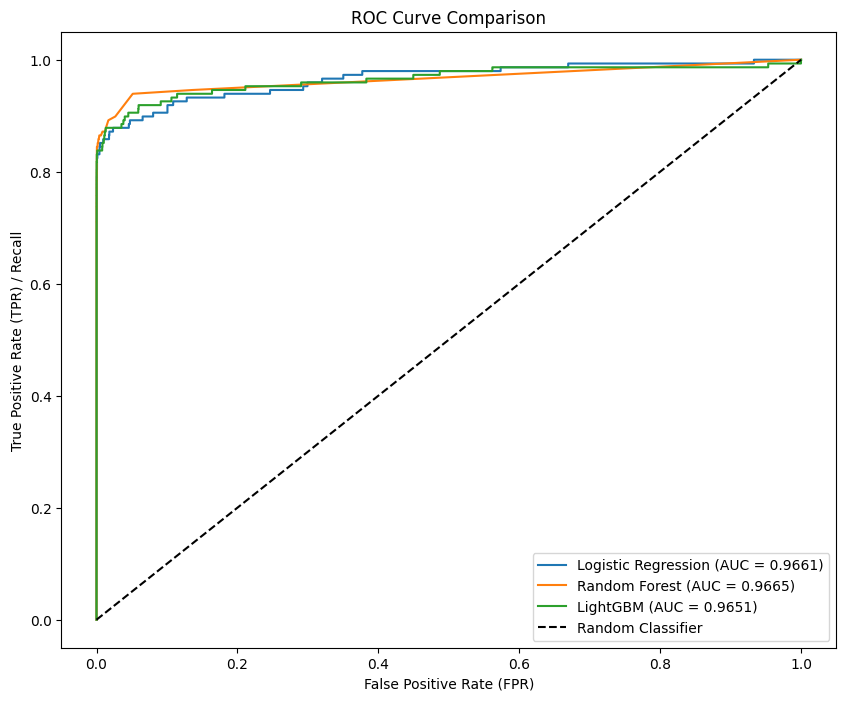

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 8))

# 로지스틱 회귀
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_lr):.4f})')

# 랜덤 포레스트
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.4f})')

# LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_proba_lgb)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_score(y_test, y_proba_lgb):.4f})')

# 기준선 (Random Classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

### **4.3. 최종 결론 및 향후 계획**

#### **4.3.1. 최종 결론**
이 프로젝트는 **재현율(Recall)**을 핵심 평가지표로 삼아 이상 거래를 탐지하는 모델을 구축했습니다. 여러 모델을 비교한 결과, **로지스틱 회귀 모델**이 가장 높은 재현율을 기록하여 이 문제에 가장 적합한 모델로 선정되었습니다.

이 과정을 통해 다음과 같은 중요한 결론을 얻었습니다:
- 데이터 분석 단계에서 발견한 **클래스 불균형**과 같은 문제점들이 모델 성능에 직접적인 영향을 미친다는 점.
- 이상 거래 탐지에서는 **비즈니스 목표에 따라 적절한 평가 지표를 선택하는 것이 매우 중요**하며, 단순한 정확도만으로는 모델의 진정한 성능을 평가할 수 없다는 점.

#### **4.3.2. 향후 개선 방안**
이 프로젝트는 성공적으로 이상 거래 탐지 모델을 구축했지만, 여전히 개선할 점이 남아 있습니다.
- **하이퍼파라미터 튜닝**: 현재는 각 모델의 기본값으로 학습했지만, 하이퍼파라미터 튜닝을 통해 재현율과 정밀도를 동시에 개선할 수 있습니다.
- **다른 샘플링 기법**: SMOTE 외에 Borderline-SMOTE, ADASYN 등 다양한 오버샘플링 기법을 비교하여 모델 성능을 높일 수 있습니다.
- **다른 알고리즘 적용**: Isolation Forest와 같은 비지도 학습 기반 이상치 탐지 알고리즘을 적용하여 성능을 비교해 볼 수 있습니다.